This note book summarizes the results of using logistic regression to determine the whether a passenger on board of the Titanic survives or not, given their social economical class, age, sex, etc. Analysis show a passengers gender, age, and social economical class are the three most important factors (in decending order). The decision boundary between survived and not survived is potentially highly nonlinear due to the nature of the data. A simple linear function (with the inputs as is) gives slightly less than 80% accuracy on a validation set that consists 40% of the total training data. A 2nd order polynormial function can improve the accuracy to around 83%. In the model, missing age was filled by mapping the title (extracted from name) to the median age in the title group.

In [24]:
import scipy.optimize as scop
import titanic_project as titan
import numpy as np
import matplotlib.pyplot as plt

features = ['Survived', 'Pclass', 'Age', 'Sex', 'SibSp', 'Parch', 'Fare','Embarked','Name']
datain = titan.readdata('train.csv', 0.6, 0.6, features)
datain['train'].describe()

,Survived,Pclass,Age,Sex,SibSp,Parch,Fare,Embarked
count,535.000000,535.000000,424.000000,535.000000,535.000000,535.000000,535.000000,535.000000
mean,0.386916,2.325234,29.266509,-0.256075,0.549533,0.370093,31.716035,1.366355
std,0.487500,0.829477,14.434267,0.967562,1.125494,0.767702,47.259528,0.676234
min,0.000000,1.000000,0.750000,-1.000000,0.000000,0.000000,0.000000,-3.000000
25%,0.000000,2.000000,20.875000,-1.000000,0.000000,0.000000,7.925000,1.000000
50%,0.000000,3.000000,28.000000,-1.000000,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,37.250000,1.000000,1.000000,0.000000,29.885400,2.000000
max,1.000000,3.000000,71.000000,1.000000,8.000000,5.000000,512.329200,3.000000


In [25]:
datain['train'].dropna(how='any').corr()

,Survived,Pclass,Age,Sex,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.285660,-0.094232,0.559736,-0.029968,0.101782,0.210668,0.074648
Pclass,-0.285660,1.000000,-0.359838,-0.140481,0.085795,0.008385,-0.587926,-0.094167
Age,-0.094232,-0.359838,1.000000,-0.091064,-0.353861,-0.238634,0.083645,0.018236
Sex,0.559736,-0.140481,-0.091064,1.000000,0.069462,0.167201,0.183197,0.061273
SibSp,-0.029968,0.085795,-0.353861,0.069462,1.000000,0.414155,0.167069,0.021752
Parch,0.101782,0.008385,-0.238634,0.167201,0.414155,1.000000,0.252656,-0.072881
Fare,0.210668,-0.587926,0.083645,0.183197,0.167069,0.252656,1.000000,0.142913
Embarked,0.074648,-0.094167,0.018236,0.061273,0.021752,-0.072881,0.142913,1.000000


The correlation table shows that the most important features are the gender (Sex), social economical class (Pclass and to some extent Fare, those two features are closely correlated). Where the passenger embarked and the sibling spouse count doesn't matter too much. Age is not insignificant, however it is missing in 26% of the training records as shown here. All other features contains no NaN values in the training set.

In [26]:
datain['train'].isnull().sum() * 1.0 / datain['train'].count()

Survived    0.000000
Pclass      0.000000
Age         0.261792
Sex         0.000000
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Embarked    0.000000
Name        0.000000
dtype: float64

Given the potential important of Age I attempt to correlate it to other parameters to improve the final model. The correlation table shows that Age correlates well with Pclass, SibSp, and Parch. After examining the names I find the title in the names, e.g., Mr, could also be used to correlate to age because each title group seem to have a distinct median age.

In [27]:
tmap = {' Mr':0, ' Mrs':1, ' Miss':2, ' Mme':1, ' Master':3}
title = datain['train'].Name.apply(titan.name2title).map(tmap).fillna(4).astype(int)

In [28]:
datain['train'] = datain['train'].assign(title = title.values)
title = datain['validation'].Name.apply(titan.name2title).map(tmap).fillna(4).astype(int)
datain['validation'] = datain['validation'].assign(title = title.values)

datain['train'].corr()

,Survived,Pclass,Age,Sex,SibSp,Parch,Fare,Embarked,title
Survived,1.000000,-0.270099,-0.094232,0.571729,-0.046940,0.087018,0.205579,0.108864,0.411510
Pclass,-0.270099,1.000000,-0.359838,-0.115367,0.101060,0.001775,-0.586986,0.054265,-0.051237
Age,-0.094232,-0.359838,1.000000,-0.091064,-0.353861,-0.238634,0.083645,0.018236,-0.314928
Sex,0.571729,-0.115367,-0.091064,1.000000,0.070997,0.168163,0.180971,0.115029,0.597094
SibSp,-0.046940,0.101060,-0.353861,0.070997,1.000000,0.440383,0.181967,-0.041111,0.309132
Parch,0.087018,0.001775,-0.238634,0.168163,0.440383,1.000000,0.260505,-0.124586,0.261974
Fare,0.205579,-0.586986,0.083645,0.180971,0.181967,0.260505,1.000000,0.038452,0.147810
Embarked,0.108864,0.054265,0.018236,0.115029,-0.041111,-0.124586,0.038452,1.000000,0.103845
title,0.411510,-0.051237,-0.314928,0.597094,0.309132,0.261974,0.147810,0.103845,1.000000


The new correlation matrix show that title is second to Sex in correlation to survived. The reason is title contains Sex information, e.g., Mr is male and Miss is female. It also contains Age information, e.g., Masters are children and have younger ages. I treat it as a new class of feature. The SibSp, while not very correlatable to Survived, does correlate well to Age. However, it does have a very large spread at a given SibSp value (figure below)

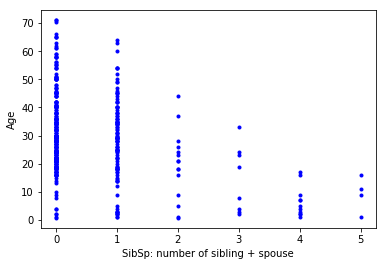

In [18]:
plt.plot(datain['train'].SibSp, datain['train'].Age, '.b')
plt.xlabel('SibSp: number of sibling + spouse')
plt.ylabel('Age')
plt.show()

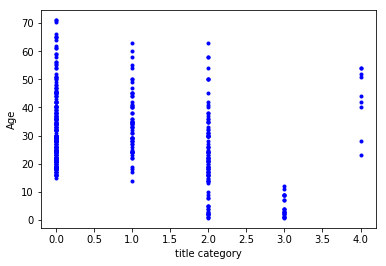

In [19]:
plt.plot(datain['train'].title, datain['train'].Age, '.b')
plt.xlabel('title category')
plt.ylabel('Age')
plt.show()

Compared to SibSp the title feature has less a spread at a given category therefore I map age to each title category. Furthermore, title is better at separating younger and older ages. For those missing Age in the database I use the median age for respective titles (extracted from the figure above) to fill in the blank.

In [45]:
import pandas as pd
def readdata(fname, tp, vstart, features):
    train = pd.read_csv(fname)
    """ only use a small subset of features for now"""
    trainlean = train.loc[:, features]
    """ digitize string values """
    trainlean.loc[:, 'Sex'] = trainlean.loc[:, 'Sex'].apply(titan.gendertonum)
    trainlean.loc[:, 'Embarked'] = trainlean.loc[:, 'Embarked'].apply(titan.embarknum)
    
    """ extract titles and map titles to age for those missing age in db """
    tmap = {' Mr':0, ' Mrs':1, ' Miss':2, ' Mme':1, ' Master':3}
    title = trainlean.Name.apply(titan.name2title).map(tmap).fillna(4).astype(int)
    medage = trainlean.groupby(title)['Age'].median()
    trainlean.loc[trainlean.Age.isnull(), 'Age'] = \
                  title[trainlean['Age'].isnull()].map(medage)
    trainlean = trainlean.assign(title = title.values)
    del trainlean['Name']   
  
    m = trainlean.shape[0]
    trainset = trainlean.loc[:int(tp * m), :]
    vadset = trainlean.loc[int(vstart * m):, :]
    
    return {'train':trainset, 'validation':vadset}

In [66]:
features = ['Survived', 'Pclass', 'Age', 'Sex', 'SibSp', 'Parch', 'Fare','Embarked','Name']
datain = readdata('train.csv', 0.6, 0.6, features)
datain['train'].describe()

,Survived,Pclass,Age,Sex,SibSp,Parch,Fare,Embarked,title
count,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000
mean,0.386916,2.325234,28.997196,-0.256075,0.549533,0.370093,31.716035,1.366355,0.809346
std,0.487500,0.829477,13.141558,0.967562,1.125494,0.767702,47.259528,0.676234,1.049838
min,0.000000,1.000000,0.750000,-1.000000,0.000000,0.000000,0.000000,-3.000000,0.000000
25%,0.000000,2.000000,21.000000,-1.000000,0.000000,0.000000,7.925000,1.000000,0.000000
50%,0.000000,3.000000,30.000000,-1.000000,0.000000,0.000000,14.454200,1.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,1.000000,0.000000,29.885400,2.000000,2.000000
max,1.000000,3.000000,71.000000,1.000000,8.000000,5.000000,512.329200,3.000000,4.000000


First, I use just linear terms (features as is) to train a logistic regression model with the training set data then I find the accuracy on the validation set. 

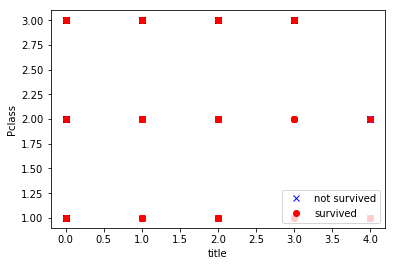

In [67]:
X = np.array(datain['train'].ix[:,1:])
y = np.array(datain['train'].ix[:,0])

Xvad = np.array(datain['validation'].ix[:,1:])
yvad = np.array(datain['validation'].ix[:,0])

X = titan.normdata(X)
Xvad = titan.normdata(Xvad)
X = np.concatenate((np.ones(shape=(X.shape[0], 1)), X), axis = 1)
Xvad = np.concatenate((np.ones(shape=(Xvad.shape[0], 1)), Xvad), axis = 1)

plt.plot(datain['train'].title[y==0], datain['train'].Pclass[y==0], 'xb')
plt.plot(datain['train'].title[y==1], datain['train'].Pclass[y==1], 'or')
plt.xlabel('title')
plt.ylabel('Pclass')
plt.legend(['not survived', 'survived'])
plt.show()

The figure above shows the potential difficulty of a linear logistic regression. Most of the important features, like Sex, title, and Pclass are discrete sets of small numbers. As a result, there is heavy overlap of the outcome (survived or not) that makes drawing of decision boundary very difficult. 

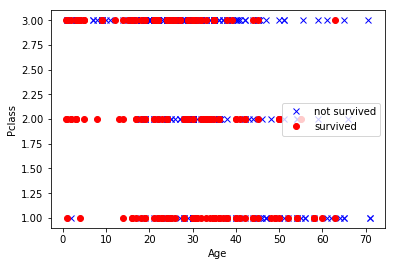

In [68]:
plt.plot(datain['train'].Age[y==0], datain['train'].Pclass[y==0], 'xb')
plt.plot(datain['train'].Age[y==1], datain['train'].Pclass[y==1], 'or')
plt.xlabel('Age')
plt.ylabel('Pclass')
plt.legend(['not survived', 'survived'])
plt.show()

Continous features like Age helps separatong the outcomes (Figure above) but still suffers from heavy overlap

In [69]:
nfeature = X.shape[1]
theta0 = np.zeros(shape = (nfeature, 1))
regpara = 1.0
w = scop.fmin_l_bfgs_b(titan.lfCost, theta0, titan.lfGradient, (X, y, regpara))
titan.getacu(w[0], X, y)

0.81121495327102799

The linear model scores a 81% accuracy on the training set.

In [70]:
titan.getacu(w[0], Xvad, yvad)

0.79271708683473385

And 79% on the validation set. Below I calculate the learning curve for the model.

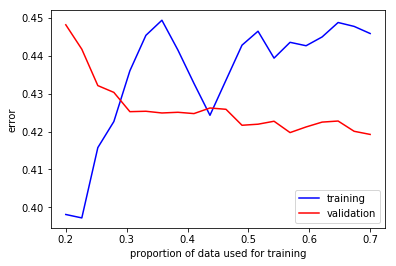

In [71]:
tp = np.linspace(0.2, 0.7, 20)
trainerror = np.zeros(shape = (tp.size, 1))
vaderror = np.zeros(shape = (tp.size, 1))
for i in range(0, tp.size):
    datain = readdata('train.csv', tp[i], 0.7, features)
    X = np.array(datain['train'].ix[:,1:])
    y = np.array(datain['train'].ix[:,0])
    Xvad = np.array(datain['validation'].ix[:,1:])
    yvad = np.array(datain['validation'].ix[:,0])
    X = titan.normdata(X)
    Xvad = titan.normdata(Xvad)
    X = np.concatenate((np.ones(shape=(X.shape[0], 1)), X), axis = 1)
    Xvad = np.concatenate((np.ones(shape=(Xvad.shape[0], 1)), Xvad), axis = 1)

    nfeature = X.shape[1]
    theta0 = np.zeros(shape = (nfeature, 1))
    regpara = 1.0
    theta = scop.fmin_l_bfgs_b(titan.lfCost, theta0, titan.lfGradient, (X, y, regpara))[0]
    trainerror[i] = titan.lfCost(theta, X, y, 0.0)
    vaderror[i] = titan.lfCost(theta, Xvad, yvad, 0.0)
plt.plot(tp, trainerror, '-b', tp, vaderror,'-r')
plt.xlabel('proportion of data used for training')
plt.ylabel('error')
plt.legend(['training','validation'])
plt.show()

The plot above shows that the errors are quite large in the model. Suggesting there is room for more features to improve the model.

As mentioned above, important features like Sex are discrete numbers that makes drawing decision boundary difficult. Combining those features with other continous ones could potentially improve the results. For example, if we multiple Age with Sex (f=1, m=-1) and plot the result we can see much better separation of the outcomes (figure below)

In [73]:
age_gender = pd.Series.copy(datain['train'].loc[:,'Age'])
age_gender[datain['train'].Sex == -1] = -age_gender[datain['train'].Sex == -1]

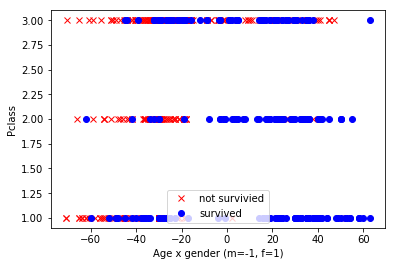

In [79]:
plt.plot(age_gender[y == 0], datain['train'].Pclass[y == 0], 'xr')
plt.plot(age_gender[y == 1], datain['train'].Pclass[y == 1], 'ob')
plt.xlabel('Age x gender (m=-1, f=1)')
plt.ylabel('Pclass')
plt.legend(['not survivied', 'survived'])
plt.show()

As a result, I consider a full 2nd order polynomail function that contains terms like $Age^2$ and $Age*Sex$ as features as well as the linear terms.

In [163]:
datain = readdata('train.csv', 0.6, 0.6, features)

X = np.array(datain['train'].ix[:,1:])
y = np.array(datain['train'].ix[:,0])

Xvad = np.array(datain['validation'].ix[:,1:])
yvad = np.array(datain['validation'].ix[:,0])

Xq = titan.normdata(titan.xquad(X))
Xvadq = titan.normdata(titan.xquad(Xvad))
Xq = np.concatenate((np.ones(shape=(Xq.shape[0], 1)), Xq), axis = 1)
Xvadq = np.concatenate((np.ones(shape=(Xvadq.shape[0], 1)), Xvadq), axis = 1)

nfeature = Xq.shape[1]
theta0 = np.zeros(shape = (nfeature, 1))
regpara = 1.0
w = scop.fmin_l_bfgs_b(titan.lfCost, theta0, titan.lfGradient, (Xq, y, regpara))

Before evaluating the results I visulize the parameters for all the quadratic terms below

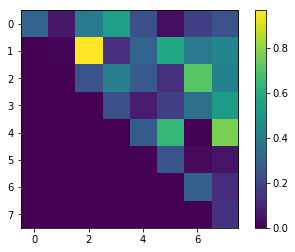

In [164]:
fullw = np.zeros(shape=(X.shape[1], X.shape[1]))
fullw[np.triu_indices(8)] = w[0][9:]
plt.imshow(np.abs(fullw))
plt.colorbar()
plt.show()

The plot above shows the relative magnitude (absolute values) of the model parameters for the quadratic terms. The item (row=1, col=2), i.e., (normalized) $Age * Sex$, has a much larger weight than other parameters. Some other unexpected parameters that has relatively harge weight are $Pclass * SibSp$ (0, 3), and $Parch * title$ (4, 7). 

In [165]:
y_predict = titan.sigmoid(np.dot(Xq,w[0]))
y_predict[y_predict > 0.5] = 1
y_predict[y_predict <= 0.5] = 0
(y_predict == y).sum()*1.0/y.size

0.83925233644859809

In [166]:
yvad_predict = titan.sigmoid(np.dot(Xvadq,w[0]))
yvad_predict[yvad_predict > 0.5] = 1
yvad_predict[yvad_predict <= 0.5] = 0
(yvad_predict == yvad).sum()*1.0/yvad.size

0.82352941176470584

Both the test set and the validation set accuracies are improved in this quadratic model. Next we analyze the model by investigating the learning curve for training set size and regularization parameter value.

For the learning curve of dataset size I use different training set sizes and a fixed validation set.

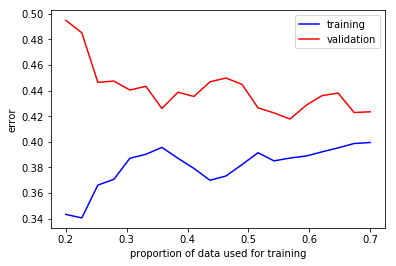

In [145]:
tp = np.linspace(0.2, 0.7, 20)
trainerror = np.zeros(shape = (tp.size, 1))
vaderror = np.zeros(shape = (tp.size, 1))
for i in range(0, tp.size):
    datain = readdata('train.csv', tp[i], 0.7, features)
    X = np.array(datain['train'].ix[:,1:])
    y = np.array(datain['train'].ix[:,0])
    Xvad = np.array(datain['validation'].ix[:,1:])
    yvad = np.array(datain['validation'].ix[:,0])
    
    Xq = titan.normdata(titan.xquad(X))
    Xvadq = titan.normdata(titan.xquad(Xvad))
    Xq = np.concatenate((np.ones(shape=(Xq.shape[0], 1)), Xq), axis = 1)
    Xvadq = np.concatenate((np.ones(shape=(Xvadq.shape[0], 1)), Xvadq), axis = 1)

    nfeature = Xq.shape[1]
    theta0 = np.zeros(shape = (nfeature, 1))
    regpara = 1.0
    theta = scop.fmin_l_bfgs_b(titan.lfCost, theta0, titan.lfGradient, (Xq, y, regpara))[0]
    trainerror[i] = titan.lfCost(theta, Xq, y, 0.0)
    vaderror[i] = titan.lfCost(theta, Xvadq, yvad, 0.0)
plt.plot(tp, trainerror, '-b', tp, vaderror,'-r')
plt.xlabel('proportion of data used for training')
plt.ylabel('error')
plt.legend(['training','validation'])
plt.show()

The learning curve indicates the model can benefit from more training examples as the gap between validation error and training error reduces with more training sets. Additionally, the training set error is smaller than the linear model, showing adding quadratic terms improves the model. The remaining gap between training and validation errors could suggest the model suffers from high variance (overfitting). I now use the 60/40 split on training/validation sets to test the learning curve for the regularization parameter. When the validation set is less than 40% the validation error starts to behave unpredictably, possibly due to small dataset size.

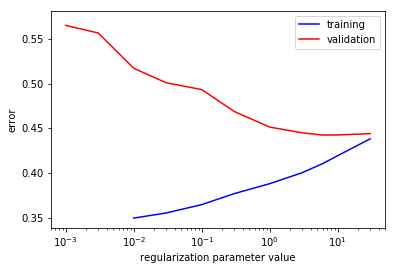

In [168]:
datain = readdata('train.csv', 0.6, 0.6, features)
X = np.array(datain['train'].ix[:,1:])
y = np.array(datain['train'].ix[:,0])
Xvad = np.array(datain['validation'].ix[:,1:])
yvad = np.array(datain['validation'].ix[:,0])
    
Xq = titan.normdata(titan.xquad(X))
Xvadq = titan.normdata(titan.xquad(Xvad))
Xq = np.concatenate((np.ones(shape=(Xq.shape[0], 1)), Xq), axis = 1)
Xvadq = np.concatenate((np.ones(shape=(Xvadq.shape[0], 1)), Xvadq), axis = 1)

theta0 = np.zeros(shape = (Xq.shape[1], 1))  
regpara = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 6, 10, 30])
trainerror = np.zeros(shape = (regpara.size, 1))
vaderror = np.zeros(shape = (regpara.size, 1))

for i in range(0, regpara.size):
    theta = scop.fmin_l_bfgs_b(titan.lfCost, theta0, titan.lfGradient, (Xq, y, regpara[i]))[0]
    trainerror[i] = titan.lfCost(theta, Xq, y, 0.0)
    vaderror[i] = titan.lfCost(theta, Xvadq, yvad, 0.0)
plt.semilogx(regpara, trainerror, '-b', regpara, vaderror,'-r')
plt.xlabel('regularization parameter value')
plt.ylabel('error')
plt.legend(['training','validation'])
plt.show()

The regularization learning curve suggests the model needs a relatively large regularization parameter (3.0), i.e., the model could be suffering from high variance with a small regularization parameter like 1.0. This agrees with results from the learning curve on training set size. 

Below I set up the model with the optimum parameters (70% training set and regularization parameter is 3.0) and the resulting accuracy is improved from the initial model.

In [177]:
datain = readdata('train.csv', 0.7, 0.7, features)
X = np.array(datain['train'].ix[:,1:])
y = np.array(datain['train'].ix[:,0])
Xvad = np.array(datain['validation'].ix[:,1:])
yvad = np.array(datain['validation'].ix[:,0])
    
Xq = titan.normdata(titan.xquad(X))
Xvadq = titan.normdata(titan.xquad(Xvad))
Xq = np.concatenate((np.ones(shape=(Xq.shape[0], 1)), Xq), axis = 1)
Xvadq = np.concatenate((np.ones(shape=(Xvadq.shape[0], 1)), Xvadq), axis = 1)

theta0 = np.zeros(shape = (Xq.shape[1], 1))  

w = scop.fmin_l_bfgs_b(titan.lfCost, theta0, titan.lfGradient, (Xq, y, 3.0))
titan.getacu(w[0], Xq, y)

0.83173076923076927

In [180]:
"""vadliation accuracy"""
titan.getacu(w[0], Xvadq, yvad) 

0.84328358208955223

Finally, to predict the results for the given test set I use all training set data with a regularization parameter of 3.0 to obtain the model parameters. Then I use those model parameters to estimate the outcome for the test set passengers.

In [ ]:
testin = readdata('tes')